# Python: Analog Inverter Chip Layout with Magic and PySpice Simulation on Sky 130nm PDK

This notebook demo how to create inverter loayout and extract analog net-list to simulate with __Sky 130 nm PDK__.
Assume you are login to any compute node in exascale.mahidol.ac.th __AI/HPC cluster__.

Considering CHIP, ASIC shortage after Covide-19, Euro WAR and Taiwan-China security and political issue. They are looking for Plan B, alternative CHIP factory. It is not goal to change country business focus but motivation for new generation to want to explore HOW TO BUID REAL CHIP as Electronics HOBBY, ASIC tape out from OpenSource EDA tools. 

## Install Conda and packages before load this Jupter Notebook

$ conda create --name chipReal
$ vi environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - magic
  - ngspice-lib
  - gdstk
  - python
  - pip
  - pip:
    - cairosvg
    - pyspice

Update conda environment:
$ conda env update --file environment.yml

PDK_ROOT=/home/snit.san/miniconda3/envs/chipReal/share/pdk
PDK_PATH=/home/snit.san/miniconda3/envs/chipReal/share/pdk/sky130A

Update PDK environment as your context.

## Draw a MOSFET Layout with magic

In [3]:
%%script bash -c "PDK_ROOT=/home/snit.san/miniconda3/envs/chipReal/share/pdk/ PDKPATH=/home/snit.san/miniconda3/envs/chipReal/share/pdk/sky130A magic -dnull -noconsole -rcfile /home/snit.san/miniconda3/envs/chipReal/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc"
cellname rename (UNNAMED) mosfet

box 0 0 950nm 650nm
paint ndiffusion

box 400nm -600nm 550nm 1200nm
paint polysilicon

box 0 0 400nm 650nm
label source
port make 3

box 550nm 0 950nm 650nm
label drain
port make 1

box 400nm -600nm 550nm 0
label gate
port make 2

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write mosfet.gds


Magic 8.3 revision 329 - Compiled on Sat Oct  8 23:33:28 UTC 2022.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(vendor): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.341-2-gde752ec
Root cell box:
           width x height  (   llx,  lly  ), (   urx,  ury  )  area (units^2)

microns:   0.950 x 0.650   ( 0.000,  0.000), ( 0.950,  0.650)  0.618     
lambda:    95.00 x 65.00   (  0.00,  0.00 ), ( 95.00,  65.00)  6175.00   
internal:    190 x 130     (     0,  0    ), (   190,  130  )  24700     
Root cell box:
           width x height  (   llx,  lly  ), (   urx,  ury  )  area

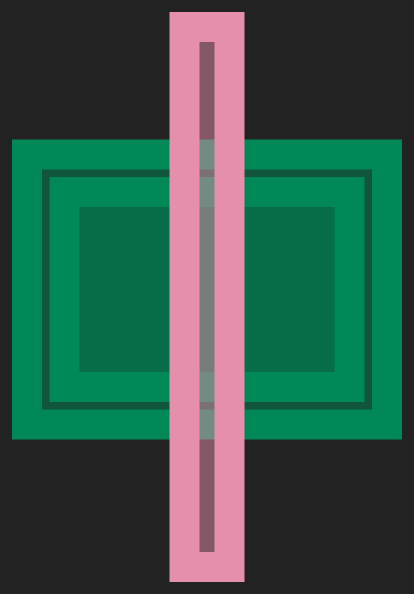

In [4]:
import gdstk
import cairosvg
from IPython.display import Image

library = gdstk.read_gds('mosfet.gds')
top_cells = library.top_level()
top_cells[0].write_svg('mosfet.svg')
cairosvg.svg2png(url='mosfet.svg', write_to='mosfet.png', scale=30.0)
Image('mosfet.png')

## Simulate the MOFSET with PySpice

.title mosfet0
.include /home/snit.san/chip_design_tape_out/analog_sim/mosfet.spice
.lib /home/snit.san/miniconda3/envs/chipReal/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice tt
Xmosfet0 DRAIN GATE VGND mosfet
Vgnd VGND 0 0
Vdd VPWR VGND 1.8
R VPWR DRAIN 10k
VVin GATE VGND DC 0V PULSE(0V 1.8V 1ns 10ps 10ps 1ns 2ns)

done


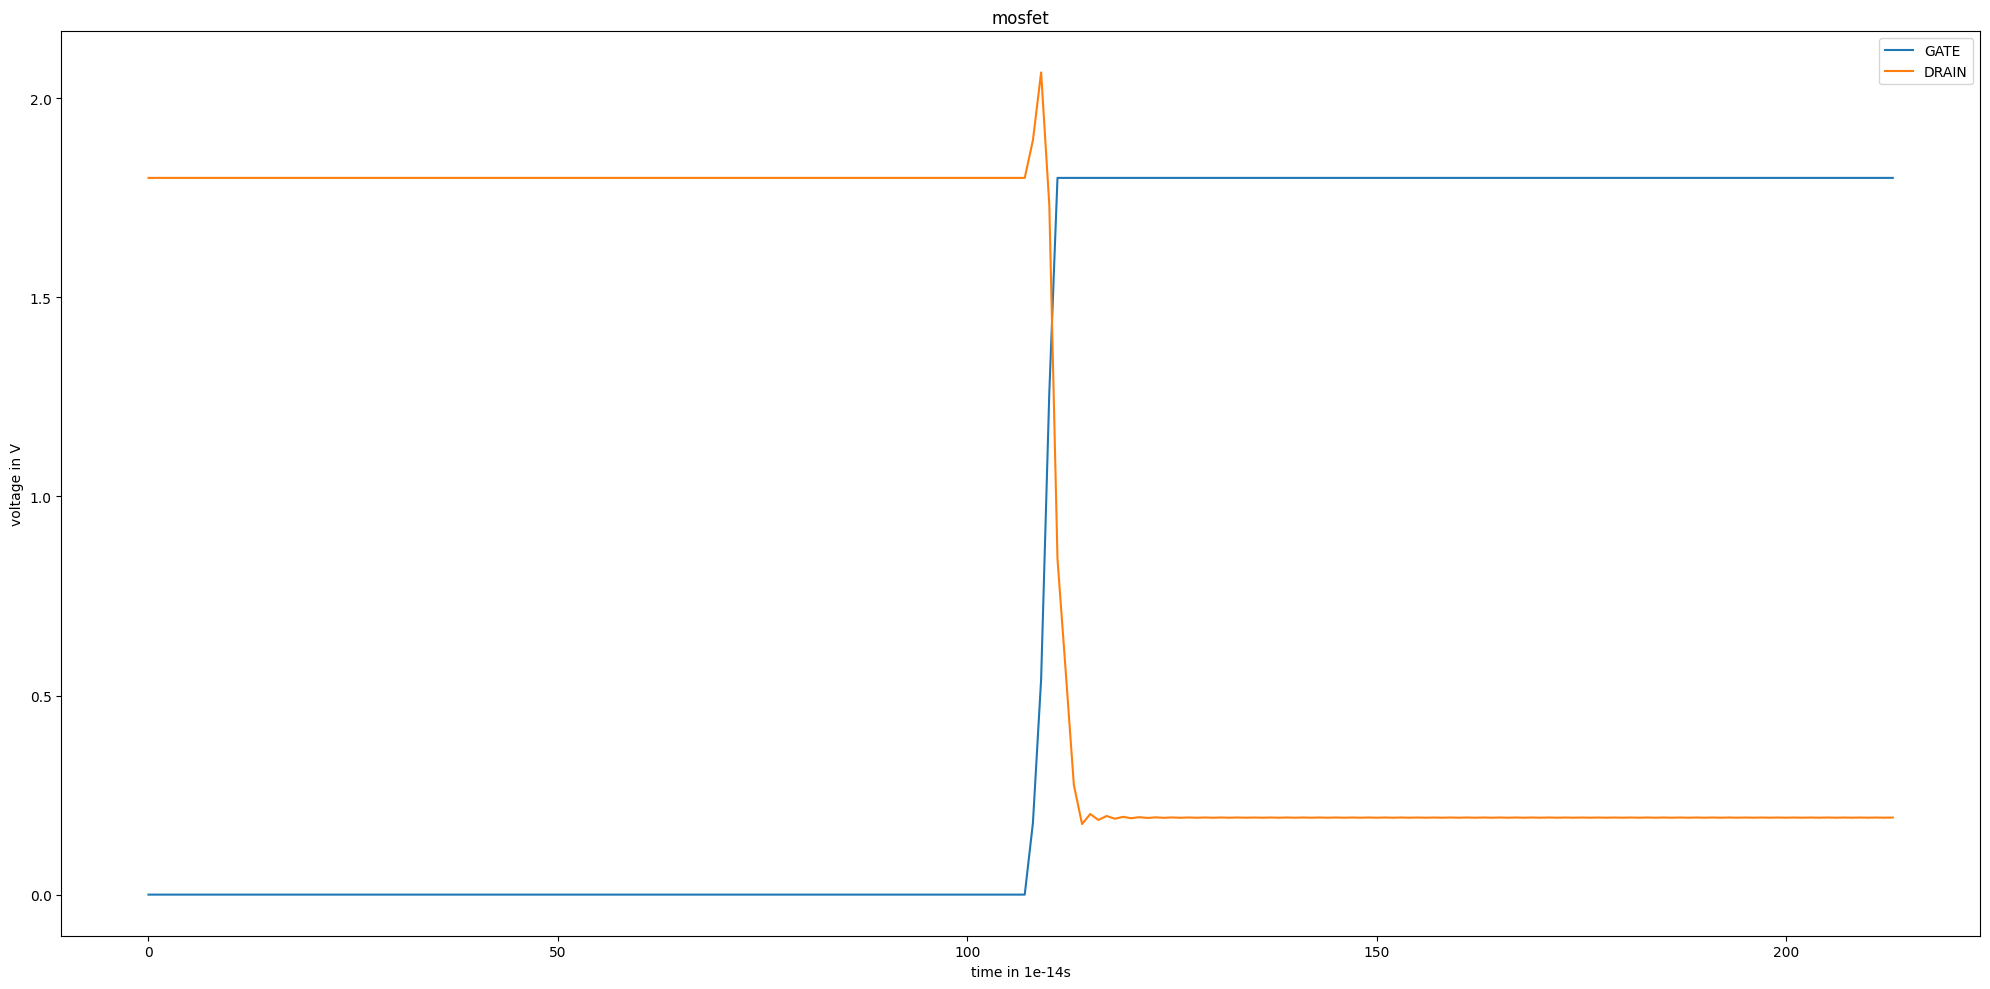

In [6]:
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Unit import *
import matplotlib.pyplot as plt

circuit = Circuit('mosfet0')
circuit.lib('/home/snit.san/miniconda3/envs/chipReal/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice', 'tt')
circuit.include('mosfet.spice')
circuit.X('mosfet0', 'mosfet', 'DRAIN', 'GATE', 'VGND')
circuit.V('gnd', 'VGND', 0, 0)
circuit.V('dd', 'VPWR', 'VGND', 1.8)
circuit.R('', 'VPWR', 'DRAIN', '10k')
circuit.PulseVoltageSource('Vin', 'GATE', 'VGND',
                           initial_value=0@u_V, pulsed_value=1.8@u_V,
                           rise_time=10@u_ps, fall_time=10@u_ps,
                           pulse_width=1@u_ns, period=2@u_ns, delay_time=1@u_ns)
print(str(circuit))
simulator = circuit.simulator()
analysis = simulator.transient(step_time=10@u_ps, end_time=2@u_ns)
print('done')
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('mosfet')
ax.set_xlabel('time in 1e-14s')
ax.set_ylabel('voltage in V')
ax.plot(analysis.GATE)
ax.plot(analysis.DRAIN)
ax.legend(('GATE', 'DRAIN'))
plt.tight_layout()
plt.show()

References/Sources:

1. Digital inverter with OpenLane
https://developers.google.com/silicon/guides/digital-inverter-openlane